In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
import pickle
import pandas as pd


In [4]:
np.random.seed(0)

In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
assert(X_train.shape[0] == y_train.shape[0]), "#images != #labels"
assert(X_val.shape[0] == y_val.shape[0]), "#images != #labels"
assert(X_test.shape[0] == y_test.shape[0]), "#images != #labels"
assert(X_train.shape[1:] == (32, 32, 3)), "dim of images != 32x32x3"
assert(X_val.shape[1:] == (32, 32, 3)), "dim of images != 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3)), "dim of images != 32x32x3"

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

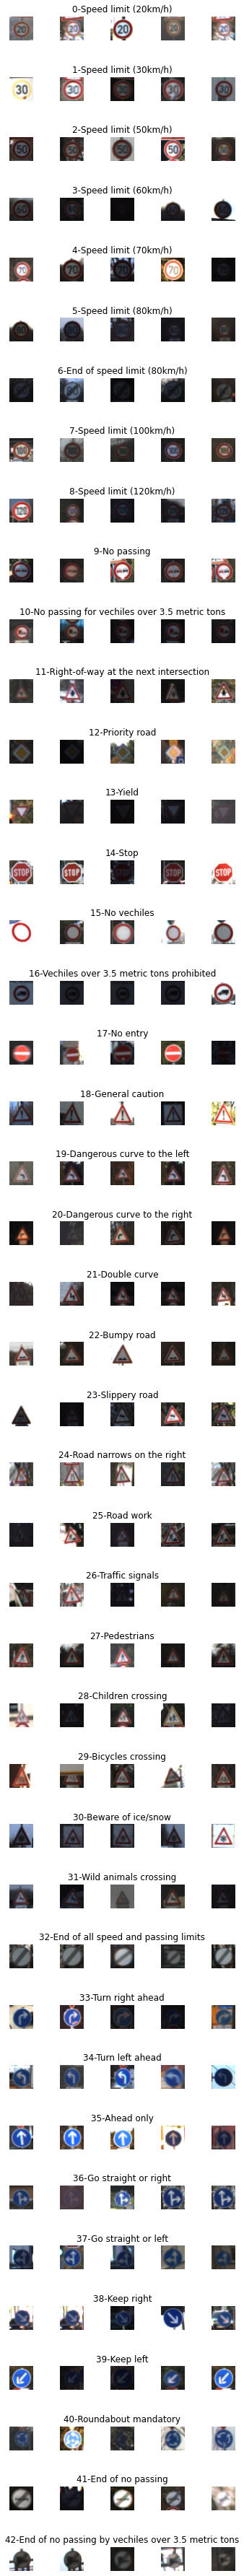

In [8]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

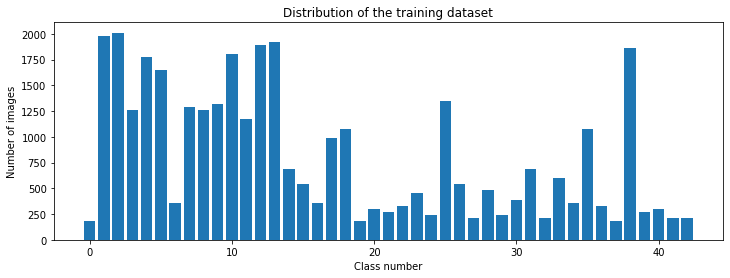

In [9]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


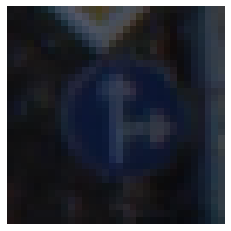

In [10]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


In [11]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


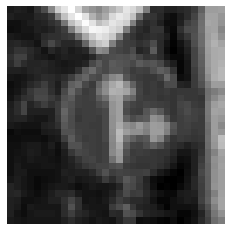

In [12]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

In [13]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

(-0.5, 31.5, 31.5, -0.5)

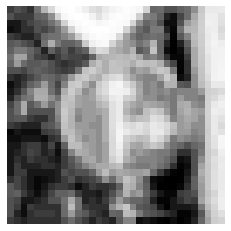

In [14]:
img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")


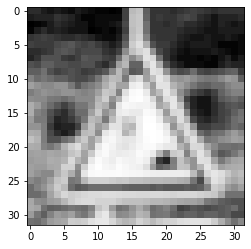

In [15]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap = 'gray')

X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)



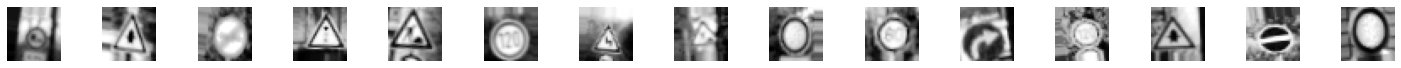

In [16]:
#augmented image
from keras.preprocessing.image import ImageDataGenerator
dataGen = ImageDataGenerator( width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.2,
                shear_range=0.1,
                rotation_range=10)
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
  axs[i].axis('off')

In [17]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [18]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
 # model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  model.compile(Adam(0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
  return model


In [19]:
model = modified_model()
history = model.fit_generator(dataGen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=695,
                            epochs=20,
                            validation_data=(X_val, y_val), shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
695/695 [==============================] - 32s 24ms/step - loss: 1.7258 - accuracy: 0.5109 - val_loss: 0.2676 - val_accuracy: 0.9156
Epoch 2/20
695/695 [==============================] - 16s 23ms/step - loss: 0.5147 - accuracy: 0.8414 - val_loss: 0.1564 - val_accuracy: 0.9451
Epoch 3/20
695/695 [==============================] - 16s 22ms/step - loss: 0.3088 - accuracy: 0.9050 - val_loss: 0.0889 - val_accuracy: 0.9737
Epoch 4/20
695/695 [==============================] - 15s 22ms/step - loss: 0.2354 - accuracy: 0.9267 - val_loss: 0.0786 - val_accuracy: 0.9755
Epoch 5/20
695/695 [==============================] - 16s 23ms/step - loss: 0.1905 - accuracy: 0.9403 - val_loss: 0.1026 - val_accuracy: 0.9680
Epoch 6/20
695/695 [==============================] - 16s 23ms/step - loss: 0.1653 - accuracy: 0.9488 - val_loss: 0.0969 - val_accuracy: 0.9744
Epoch 7/20
695/695 [==============================] - 16s 23ms/step - loss: 0.1449 - accuracy: 0.9558 - val_loss: 0.0800 - val_accuracy:

Text(0.5, 0, 'epoch')

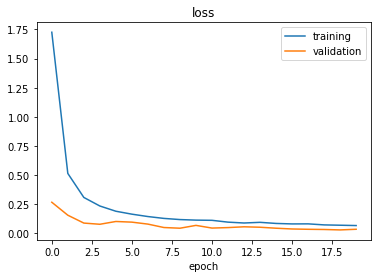

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

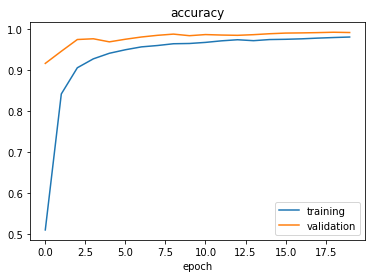

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.1056722104549408
Test Accuracy: 0.9713380932807922


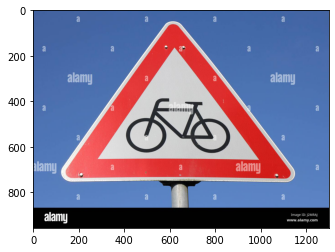

In [23]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 


(32, 32)
predicted sign: [24]


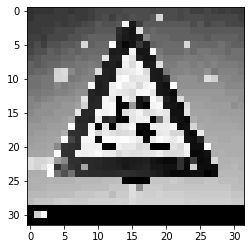

In [24]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis =-1 )))